# **EDA Switzerland Story-telling**

# Story-Inputs

## Ideas

**Story-Inputs**:
- Involve the readers interests (Skiing)
- Progression of tourists in winter region/cable car usage

**Start the Story**
- Skier asks himself regarding to all the climate change if it will be possible to ski in the future and then he does some research
- Guy talks with his grandma who's living in a famous skiing area in Switzerland and she tells him that every year they have less snow -> Guy starts with research about this topic

# Data Import

Set all import paths for this project

In [4]:
import sys
import os

database_path = 'C:\\Users\\simon\\Desktop\\FS2020-Project-Climate-Change\\database'
print(sys.path)

def import_system_path():
    if database_path not in sys.path:
        sys.path.append(database_path)
        print('New path added to Sys.')
    else:
        print('Path already exists.')
        
import_system_path()

['C:\\Users\\simon\\Desktop\\FS2020-Project-Climate-Change\\storytelling', 'C:\\Users\\simon\\anaconda3\\python37.zip', 'C:\\Users\\simon\\anaconda3\\DLLs', 'C:\\Users\\simon\\anaconda3\\lib', 'C:\\Users\\simon\\anaconda3', '', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\simon\\.ipython']
New path added to Sys.


In [19]:
from DBA import DBA
import yaml


import pandas as pd
import numpy as np
import datetime

import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import plotly.express as px
import plotly.graph_objects as go


sns.set_style("darkgrid")

Read YML-File with Configuration data for database

In [ ]:
a_yaml_file = open("config.yml")
parsed_yaml_file = yaml.load(a_yaml_file, Loader=yaml.FullLoader)
print(parsed_yaml_file)

## DB Connection

Create connection object with all DB configurations

In [ ]:
connection_object = DBA(parsed_yaml_file['sql']['db'], 
                        parsed_yaml_file['sql']['user'] , 
                        parsed_yaml_file['sql']['pw'] , 
                        parsed_yaml_file['sql']['host'], 
                        parsed_yaml_file['sql']['port']
                       )

Test-Query

## All Queries

In [ ]:
class Queries():
    
    switzerland_temperature = """select locations.location_id, locations.country, 
                                 sensors.sensor_id, sensors.sensor_type,
                                 sensor_readings.timestamp, sensor_readings.int_reading, sensor_readings.float_reading, sensor_readings.bool_reading
                                 from locations
                                 inner join sensors on (sensors.location_id = locations.location_id)
                                 inner join sensor_readings on (sensors.sensor_id = sensor_readings.sensor_id)
                                 where locations.country = 'Switzerland' and (sensors.sensor_type = 'temperature')
                                 order by timestamp"""
    
    switzerland_co2 = """select locations.location_id, locations.country, 
                         sensors.sensor_id, sensors.sensor_type,
                         sensor_readings.timestamp, sensor_readings.int_reading, sensor_readings.float_reading, sensor_readings.bool_reading
                         from locations
                         inner join sensors on (sensors.location_id = locations.location_id)
                         inner join sensor_readings on (sensors.sensor_id = sensor_readings.sensor_id)
                         where locations.country = 'Switzerland' and (sensors.sensor_type = 'co2')
                         order by timestamp"""
    
    regions_newsnow = """select locations.location_id, locations.region, 
                         sensors.sensor_id, sensors.sensor_type,
                         sensor_readings.int_reading, sensor_readings.timestamp
                         from locations
                         inner join sensors on (sensors.location_id = locations.location_id)
                         inner join sensor_readings on (sensors.sensor_id = sensor_readings.sensor_id)
                         where locations.region is not NULL
                         order by region, timestamp"""

    

## Query Data

In [ ]:
switzerland_temp = connection_object.query_data(Queries.switzerland_temperature)
switzerland_co2 = connection_object.query_data(Queries.switzerland_co2)
switzerland_newsnow = connection_object.query_data(Queries.regions_newsnow)

## Transform

In [ ]:
def transform_switzerland_temp(swiss_temp):
    swiss_temp = swiss_temp.drop(['int_reading', 'bool_reading'], axis=1)
    swiss_temp = swiss_temp.set_index('timestamp', drop=True)
    swiss_temp.index = pd.to_datetime(swiss_temp.index)
    swiss_temp = swiss_temp.loc[:, ['float_reading']]
    swiss_temp.columns = ['temperature']
    
    amt_missing_values = swiss_temp[swiss_temp['temperature'].isna() == True].shape[0]
    if amt_missing_values > 0:
        plot = sns.distplot(swiss_temp[swiss_temp['temperature'].isna() == True].index.year, bins=50)
        plot.set_title('Missing Values in years / Amount: {}'.format(amt_missing_values))
        plt.show()
 
    swiss_temp = swiss_temp.dropna()
    
    return swiss_temp

def transform_switzerland_co2(swiss_co2):
    swiss_co2 = swiss_co2.drop(['int_reading', 'bool_reading'], axis=1)
    swiss_co2 = swiss_co2.set_index('timestamp', drop=True)
    swiss_co2.index = pd.to_datetime(swiss_co2.index)
    swiss_co2 = swiss_co2.loc[:, ['float_reading']]
    swiss_co2.columns = ['CO2']
    
    amt_missing_values = swiss_co2[swiss_co2['CO2'].isna() == True].shape[0]
    if amt_missing_values > 0:
        plot = sns.distplot(swiss_co2[swiss_co2['CO2'].isna() == True].index.year, bins=50)
        plot.set_title('Missing Values in years / Amount: {}'.format(amt_missing_values))
        plt.show()
    
    swiss_co2 = swiss_co2.dropna()
    
    return swiss_co2


def transform_newsnow(data):
    data = data.loc[:,['timestamp', 'region', 'int_reading']]
    #data = pd.pivot_table(data=data, values='int_reading', index='timestamp', columns='region')
    data = data.set_index('timestamp')
    data.index = pd.to_datetime(data.index)
    data = data.sort_values(by='timestamp')
    data.columns = ['region', 'new_snow']

    return data


In [ ]:
switzerland_temp = transform_switzerland_temp(switzerland_temp)  
switzerland_co2 = transform_switzerland_co2(switzerland_co2)
switzerland_newsnow = transform_newsnow(switzerland_newsnow)

In [ ]:
sns.lineplot(switzerland_co2.index.year, switzerland_co2['CO2'])

# Analysis Temperature/CO2

Analysis of the Temperature and CO2 values of Switzerland

Check which are the time differences between each measurement of CO2 and temperature

In [ ]:
not_local_data.sample(2)

In [ ]:
temperature_switzerland = not_local_data[not_local_data['sensor_type'] == 'temperature']
temperature_switzerland = temperature_switzerland.set_index(temperature_switzerland['timestamp'])
temperature_switzerland.index = pd.to_datetime(temperature_switzerland.index)

time_shifted = temperature_switzerland.loc[:,'timestamp'].shift(1) 
time_diff = temperature_switzerland.loc[:,'timestamp'] - time_shifted
print('Temperature Measurement differences: {}'.format(time_diff.mean()))

temperature_switzerland.head()

In [ ]:
co2_switzerland = not_local_data[not_local_data['sensor_type'] == 'co2']
co2_switzerland = co2_switzerland.set_index(co2_switzerland['timestamp'])
co2_switzerland.index = pd.to_datetime(co2_switzerland.index)


time_shifted = co2_switzerland.loc[:,'timestamp'].shift(1) 
time_diff = co2_switzerland.loc[:,'timestamp'] - time_shifted
print('CO2 Measurement differences: {}'.format(time_diff.mean()))

co2_switzerland.head()

## Time Linechart

In [ ]:
def plot_temperature_international(rolling_mean):
    fig, ax = plt.subplots(2, 1, figsize=(12,10))
    
    time_from = '1960-01-01'
    time_to =  2020
    
    temperature_switzerland = not_local_data[not_local_data['sensor_type'] == 'temperature']
    temperature_switzerland = temperature_switzerland.loc[:, ['timestamp', 'float_reading']]
    
    co2_switzerland = not_local_data[not_local_data['sensor_type'] == 'co2']
            
    p1_y = not_local_data[not_local_data['sensor_type'] == 'temperature']['timestamp']
    p1_y = p1_y[p1_y > pd.to_datetime(time_from)]
    
    p1 = sns.lineplot(x=p1_y, 
                      y=temperature_switzerland['float_reading'].rolling(rolling_mean).mean(), ax=ax[0])
    p3 = sns.lineplot(x=p1_y, y=temperature_switzerland['float_reading'].rolling(6).mean(), ax=ax[0])
    p1.set_title('Temperature of Switzerland with {} month Rolling Average'.format(rolling_mean), loc='left')
    p1.set(ylabel='Temperature in C°', xlabel=('Years'))

    p2 = sns.lineplot(x=not_local_data[not_local_data['sensor_type'] == 'co2']['timestamp'], 
                      y=co2_switzerland['float_reading'], ax=ax[1])
    p2.set_title('CO2 of Switzerland cumulative each year', loc='left')
    p2.set(ylabel='CO2', xlabel=('Years'))
    
    plt.show()

plot_temperature_international(6*12)

## Distribution of the Data

In [ ]:
def boxplot_temp_co2():
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    p1 = sns.boxplot(temperature_switzerland['float_reading'], ax=ax[0])
    p1.set_title('Temperature Readings Switzerland from {} to {}'.format(temperature_switzerland.index[0].year, temperature_switzerland.index[-1].year))
    p1.set_xlabel('Temperature in C°')
    
    p2 = sns.boxplot(co2_switzerland['float_reading'], ax=ax[1])
    p2.set_title('CO2 Readings Switzerland from {} to {}'.format(co2_switzerland.index[0].year, co2_switzerland.index[-1].year))
    p2.set_xlabel('CO2')
    plt.show()
    
boxplot_temp_co2()

def distribution_temp_co2():

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    p1 = sns.distplot(temperature_switzerland['float_reading'], bins=int(np.sqrt(temperature_switzerland.shape[0])), ax=ax[0])
    p1.set_title('Temperature Readings Switzerland from {} to {}'.format(temperature_switzerland.index[0].year, temperature_switzerland.index[-1].year))
    p1.set_xlabel('Temperature in C°')
    
    p2 = sns.distplot(co2_switzerland['float_reading'], bins=int(np.sqrt(co2_switzerland.shape[0])), ax=ax[1])
    p2.set_title('CO2 Readings Switzerland from {} to {}'.format(co2_switzerland.index[0].year, co2_switzerland.index[-1].year))
    p2.set_xlabel('CO2')
    plt.show()

distribution_temp_co2()

Calculation of the Pearson correlation between the two variables of all data available. For the same timestamp I resampled the temperature from one month to one year and took the mean of it, because of the fact we don't have massive outliers in our dataframe.

## Pearson Correlation 

In [ ]:
def temp_co2_correlation():
    temp_from_1960_yearly = temperature_switzerland.loc[temperature_switzerland.index > pd.to_datetime('1960-01-01')]['float_reading']
    temp_from_1960_yearly.index = pd.to_datetime(temp_from_1960_yearly.index)

    temp_from_1960_yearly = temp_from_1960_yearly.resample('Y').mean()
    temp_from_1960_yearly.tail()
    
    co2_from_1960_yearly = co2_switzerland.loc[:'2013-01-01']['float_reading']

    corr_df = pd.concat([co2_from_1960_yearly, temp_from_1960_yearly], axis=1).resample('Y').median()
    corr_df.columns = ['CO2', 'Temperature']
    
    plot = sns.heatmap(corr_df.corr(), annot=True)
    plot.set_title('Correlation Heat Map CO2/Temperaturefrom {} to {}'.format(corr_df.index[0].year, corr_df.index[-1].year))
    plt.show()

temp_co2_correlation()

As we can see we have a medium negative correlation which probably is the effect on the upturn of the CO2 trendline at 1990. To have better measure I only take the timeframe from 1990 up to highest available data.

In [ ]:
def temp_co2_correlation():
    temp = temperature_switzerland.loc[temperature_switzerland.index > pd.to_datetime('1995-01-01')]['float_reading']
    temp.index = pd.to_datetime(temp.index)

    temp = temp.resample('Y').mean()
    
    co2 = co2_switzerland.loc[temp.index[0]:temp.index[-1]]['float_reading']
    
    corr_df = pd.concat([co2, temp], axis=1).resample('Y').median()
    corr_df.columns = ['CO2', 'Temperature']
        
    plot = sns.heatmap(corr_df.corr(), annot=True)
    plot.set_title('Correlation Heat Map CO2/Temperaturefrom {} to {}'.format(corr_df.index[0].year, corr_df.index[-1].year))
    plt.show()

temp_co2_correlation()

## Cross -and Autocorrelation

In [ ]:
def autocorr():
    
    temp =  temperature_switzerland.loc[:, ['float_reading']]
    plt.acorr(temp['float_reading'])
    plt.show()
    
    temp = temp.resample('Y').mean()
    plt.acorr(temp['float_reading'])
    plt.show()

        
    
    
    
    
autocorr()

# Analysis New Snow

In [ ]:
switzerland_newsnow.head()

In [ ]:
def plot_line_newsnow(data):
     
    plot = px.line(data, x=data.index, y='new_snow', color="region")
    return plot
    
    
plot_line_newsnow(switzerland_newsnow)

# Analysis with .CSV data

## Read Data

In [255]:
swiss_data = pd.read_excel('data_collectionklimadaten_swiss_open_data.xlsx', 
                           header=5, index_col=0 ).dropna().iloc[1:]

co2_data = pd.read_csv('co2.csv', index_col=1).drop(['Unnamed: 0'], axis=1)
co2_data.index = pd.to_datetime(co2_data.index)

temp_data = pd.read_csv('temperature_global.csv', index_col=1).drop(['Unnamed: 0'], axis=1)
temp_data.index = pd.to_datetime(temp_data.index)

##  CO2  

### Overall Sum of each country

In [32]:
def plot_co2_overall_sum():

    labels={'x':'Years', 'y':'CO2'}
    title='Continental yearly CO2 Increase'

    fig = px.line(y=co2_data.resample('Y').sum()['co2'], x=co2_data.resample('Y').median().index,
                 title=title, labels=labels)

    fig.show()
    
plot_co2_overall_sum()

### Tree Map Switzerland <> 10 Countries with highest CO2 Emission

In [191]:
import matplotlib

In [189]:
def tree_map_co2(data):
    data = data.groupby('country').sum()
    data_swiss = data[data.index == 'Switzerland']
    data_swiss.index = ['CH']
    top_players = data.sort_values('co2', ascending=False).iloc[:10]
    top_players = pd.concat([top_players, data_swiss], axis=0)
    
    # Plotting
    cmap = matplotlib.cm.Greys
    mini=min(top_players['co2'])
    maxi=max(top_players['co2'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in top_players['co2']]
 
    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=top_players['co2'] , label=top_players.index, color=colors)
    plt.title('CO2 Comparisson Switzerland and Global Big Players', loc='left')
    plt.axis('off')
    plt.show()

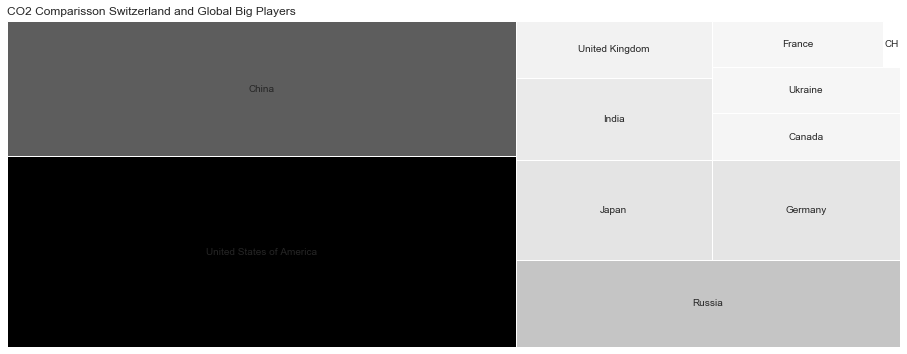

In [190]:
tree_map_co2(co2_data)

## Temperature

### Tree Map (Switzerland Comparisson to other Countries)

In [192]:
def tree_map_temp(data):
    year_to = data.index[-1].year
    data = data[data.index.year == year_to]
    data = data.groupby('country').max()
    data_swiss = data[data.index == 'Switzerland']
    data_swiss.index = ['CH']
    top_players = data.sort_values('monthly_anomaly', ascending=False).iloc[:10]
    top_players = pd.concat([top_players, data_swiss], axis=0)
    
    # Plotting
    cmap = matplotlib.cm.Reds
    mini=min(top_players['monthly_anomaly'])
    maxi=max(top_players['monthly_anomaly'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in top_players['monthly_anomaly']]
 
    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=top_players['monthly_anomaly'] , label=top_players.index, color=colors)
    plt.title('Top 10 Countries with highest Temperature Increase of the Year {}'.format(year_to), loc='left')
    plt.axis('off')
    plt.show()    


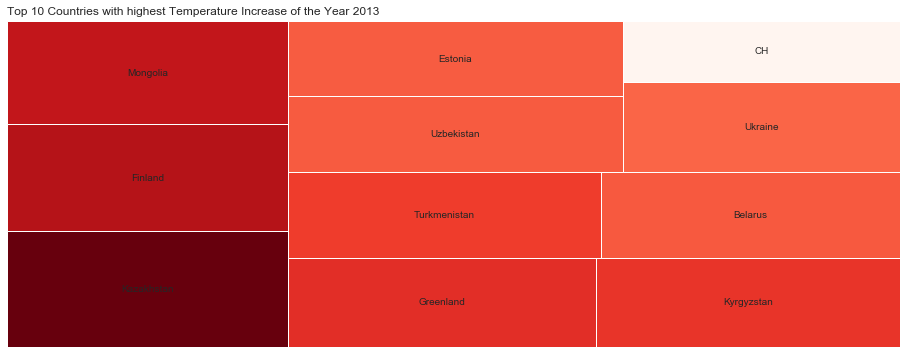

In [193]:
tree_map_temp(temp_data)  

## Swiss Local Data

In [259]:
import re

def swiss_places_column_titles(data):
    """Replaces the Header of the swiss data table with only alphabetic chars."""
    new_cols = []
    
    for i in data.columns:
        result = re.sub("[1,2)]", '', i)
        new_cols.append(result)
    data.columns = new_cols
    
    return data  

Index(['Basel-Binningen ', 'Bern-Zollikofen ', 'Davos', 'Genf-Cointrin ',
       'Locarno-Monti', 'Lugano', 'Luzern', 'Neuenburg', 'Säntis', 'Samedan',
       'Sitten', 'St. Gallen', 'Zürich-Fluntern '],
      dtype='object')


In [260]:
swiss_data = swiss_places_column_titles(swiss_data)